# Sentiment Analysis of Airline Reviews  
### Comparative Study: Turkish Airlines vs Qatar Airways

**Course:** CCS3153 – Natural Language Processing  
**Semester:** 1 (2024/2025)

## Project Objective
This project aims to perform sentiment analysis on real-world airline customer reviews and compare public sentiment between **Turkish Airlines** and **Qatar Airways**.

Using **word embeddings (Word2Vec)** and **three machine learning models**, this study evaluates sentiment polarity (positive, neutral, negative) and determines which airline is perceived more positively by customers.

## Dataset
- Source: Kaggle – Airline Reviews Dataset  
- Link: https://www.kaggle.com/datasets/sujalsuthar/airlines-reviews  
- Data Type: Public, non-copyrighted
- Time Range: 2023 

## Machine Learning Models Used
1. Logistic Regression (baseline)
2. Linear Support Vector Machine (primary model)
3. Random Forest (non-linear comparison)

This notebook presents a complete NLP pipeline:  
**Data → Preprocessing → Embeddings → Modeling → Evaluation → Visualization**



## Environment Setup

This notebook requires the following Python libraries:

- pandas, numpy
- nltk
- gensim
- scikit-learn
- matplotlib, seaborn


In [52]:
!pip install nltk gensim scikit-learn seaborn matplotlib



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


This cell loads all required libraries for data handling (pandas, numpy), NLP preprocessing (nltk), word embedding (gensim), ML models (scikit-learn), and visualization (matplotlib, seaborn).
NLTK resources are downloaded so that lemmatization and stopword removal work seamlessly.


In [53]:

# Core libraries for data handling

import pandas as pd              # For loading and manipulating tabular data
import numpy as np               # For numerical operations and arrays

# Text preprocessing libraries

import re                        # For regular expressions (text cleaning)
import nltk                      # NLP toolkit

from nltk.corpus import stopwords        # Stopword list (e.g., "the", "is")
from nltk.stem import WordNetLemmatizer  # Lemmatization (convert words to base form)


# Word embedding model

from gensim.models import Word2Vec        # Word2Vec for learning word embeddings


# Machine Learning models & tools

from sklearn.model_selection import train_test_split  # Train-test split
from sklearn.linear_model import LogisticRegression   # Baseline classifier
from sklearn.svm import LinearSVC                      # Linear SVM classifier
from sklearn.ensemble import RandomForestClassifier   # Ensemble classifier
from sklearn.metrics import classification_report, confusion_matrix  # Evaluation
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF vectorizer
from scipy.sparse import hstack, csr_matrix 
from sklearn.metrics import accuracy_score


# Visualization libraries

import matplotlib.pyplot as plt
import seaborn as sns


# Download required NLTK resources

nltk.download('punkt')       # Tokenizer
nltk.download('stopwords')   # Stopword list
nltk.download('wordnet')     # Lemmatization dictionary


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Loading

- Reads the dataset
- Displaying head() to show key columns

In [54]:
# Load the dataset from the specified path
df = pd.read_csv("airlines_reviews.csv")

# View the first few rows
df.head()


,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,February 2024,Phuket to Singapore,Economy Class,5,3,4,4,1,3,no
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,February 2024,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,yes
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,February 2024,Singapore to London Heathrow,Economy Class,5,5,5,5,5,10,yes
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,February 2024,Singapore to Phnom Penh,Economy Class,5,5,5,5,5,10,yes


## Initial Data Inspection

- To inspect the dataset structure, available columns, and basic statistics
to understand the data before preprocessing.


In [55]:
# Display dataset structure: columns, data types, missing values
df.info()

# Check how many reviews exist per airline
df['Airline'].value_counts().head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Title                   8100 non-null   object
 1   Name                    8100 non-null   object
 2   Review Date             8100 non-null   object
 3   Airline                 8100 non-null   object
 4   Verified                8100 non-null   object
 5   Reviews                 8100 non-null   object
 6   Type of Traveller       8100 non-null   object
 7   Month Flown             8100 non-null   object
 8   Route                   8100 non-null   object
 9   Class                   8100 non-null   object
 10  Seat Comfort            8100 non-null   int64 
 11  Staff Service           8100 non-null   int64 
 12  Food & Beverages        8100 non-null   int64 
 13  Inflight Entertainment  8100 non-null   int64 
 14  Value For Money         8100 non-null   int64 
 15  Over

Airline
Turkish Airlines      1685
Qatar Airways         1624
Emirates              1350
Singapore Airlines     972
Air France             798
Name: count, dtype: int64

Dataset Summary

The dataset consists of **3,309 airline customer reviews** with **17 attributes**, combining textual reviews, airline metadata, and numerical service ratings. All columns contain **complete data with no missing values**, ensuring a clean and reliable input for analysis.

The **`Reviews`** column serves as the primary textual input for sentiment analysis, while the **`Overall Rating`** column is used to derive supervised sentiment labels (positive, neutral, negative). 

## Data Selection

This project focuses only on:
- Turkish Airlines
- Qatar Airways

Filtering ensures a fair and direct comparison between two competing airlines.

In [56]:
# Define the two airlines we want to compare
target_airlines = ["Turkish Airlines", "Qatar Airways"]

# Filter the dataset to keep only reviews for these airlines
df = df[df['Airline'].isin(target_airlines)]

# Reset index after filtering for cleaner processing
df.reset_index(drop=True, inplace=True)

# Verify the filtered dataset
df['Airline'].value_counts()


Airline
Turkish Airlines    1685
Qatar Airways       1624
Name: count, dtype: int64

## Sentiment Label Definition

Customer sentiment is derived from the **Overall Rating** column:

- Rating 1–4 → Negative
- Rating 5–6 → Neutral
- Rating 7–10 → Positive

This converts numerical ratings into supervised sentiment labels.


In [57]:
# Convert numerical ratings into sentiment categories
# This creates supervised labels for machine learning
def map_sentiment(rating):
    if rating <= 4:
        return "negative"   # Low ratings indicate dissatisfaction
    elif rating <= 6:
        return "neutral"    # Mid-range ratings indicate neutrality
    else:
        return "positive"   # High ratings indicate satisfaction

# Apply sentiment mapping to the dataset
df['sentiment'] = df['Overall Rating'].apply(map_sentiment)

# Check class distribution (important for evaluation)
df['sentiment'].value_counts()


sentiment
positive    1523
negative    1507
neutral      279
Name: count, dtype: int64

## Text Consolidation

Review titles often contain strong and explicit sentiment expressions
(e.g., "Terrible experience", "Excellent service").
To enhance sentiment signal strength, the review title and the main
review text are combined into a single text field before preprocessing.


In [58]:
# Combine review title and review content into a single text field
# This strengthens sentiment cues for embedding and classification
df['full_text'] = df['Title'] + " " + df['Reviews']

# Preview combined text
df[['Title', 'Reviews', 'full_text']].head()


,Title,Reviews,full_text
0,“marred by inconveniences”,The delay of my flight from Haneda to Doha ca...,“marred by inconveniences” The delay of my fl...
1,seat wouldn't stay up,They convinced me that I needed to pay $1500...,seat wouldn't stay up They convinced me that...
2,no attempt to address our complaint,I have sent 5 emails and have only received ...,no attempt to address our complaint I have s...
3,“I hope they update the A380”,We flew on probably the first A380 the airlin...,“I hope they update the A380” We flew on prob...
4,I’d rate them maybe 7/10,"Service was ok, pretty good on my aisle and ...","I’d rate them maybe 7/10 Service was ok, pr..."


## Text Preprocessing

The review text undergoes standard NLP preprocessing:
- Lowercasing
- Removal of URLs and special characters
- Tokenization
- Stopword removal
- Lemmatization

This step reduces noise and improves embedding quality.


In [59]:
# Initialize stopword list and lemmatizer
stop_words = set(stopwords.words('english')) - {"not", "no", "never"}
lemmatizer = WordNetLemmatizer()

# Define a preprocessing function for review text
def preprocess(text):
    
    # Convert text to lowercase for consistency
    text = text.lower()
    
    # Remove URLs (if any)
    text = re.sub(r"http\S+|www\S+", "", text)
    
    # Remove punctuation, numbers, and special characters
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Tokenize text into individual words
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and apply lemmatization
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 1
    ]
    
    return tokens

# Apply preprocessing to all reviews
# Apply preprocessing to the combined text field
df['tokens'] = df['full_text'].fillna("").apply(preprocess)

# Inspect tokenized output
df['tokens'].head()

# Convert tokens back into a clean string for TF-IDF
df['clean_text'] = df['tokens'].apply(lambda x: " ".join(x))




## Word Embedding with Word2Vec

A Word2Vec model is trained on the preprocessed review corpus.
Each word is represented as a dense vector capturing semantic meaning.


In [60]:
# Train a Word2Vec model on the tokenized reviews
# vector_size = dimensionality of word vectors
# window = context window size
# min_count = minimum frequency for a word to be included

w2v_model = Word2Vec(
    sentences=df['tokens'],
    vector_size=200,
    window=7,
    min_count=2,
    workers=4
)

# Check vocabulary size learned by the model
len(w2v_model.wv)


6647

In [61]:
# Review-level embedding = average of word vectors in the review
def embed_review(tokens, model):
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])

    if len(vectors) == 0:
        return np.zeros(model.vector_size)

    return np.mean(vectors, axis=0)

# ✅ This is what you were missing:
X_w2v = np.vstack(df["tokens"].apply(lambda t: embed_review(t, w2v_model)))
y = df["sentiment"]

print("X_w2v shape:", X_w2v.shape)


X_w2v shape: (3309, 200)


In [62]:
X_w2v.shape


(3309, 200)

## Hybrid Feature Construction (TF-IDF + Word2Vec)

TF-IDF captures explicit lexical sentiment cues, while Word2Vec captures
semantic context. These representations are concatenated to form a
hybrid feature space for downstream classification.


In [63]:
# ===============================
# TF-IDF Feature Extraction
# ===============================

tfidf = TfidfVectorizer(
    max_features=7000,
    ngram_range=(1, 2),
    min_df=2
)

X_tfidf = tfidf.fit_transform(df['clean_text'])

# ===============================
# Hybrid Feature Matrix
# ===============================

from scipy.sparse import csr_matrix, hstack

X_w2v_sparse = csr_matrix(X_w2v)
X_hybrid = hstack([X_tfidf, X_w2v_sparse])


## Review-Level Embedding Construction

Each review is represented as the average of its word vectors.
This results in a fixed-length vector per review.


In [64]:
# Convert each review into a single vector
# by averaging the vectors of its words
def embed_review(tokens, model):
    vectors = []
    
    for token in tokens:
        # Use only tokens that exist in Word2Vec vocabulary
        if token in model.wv:
            vectors.append(model.wv[token])
    
    # If no valid words exist, return a zero vector
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    
    # Return the average vector
    return np.mean(vectors, axis=0)

# Create feature matrix X and target labels y
X = np.vstack(df['tokens'].apply(lambda x: embed_review(x, w2v_model)))
y = df['sentiment']


## Train–Test Split

The dataset is split into:
- 70% training
- 30% testing

Stratification ensures balanced sentiment distribution.


In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X_hybrid,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((2316, 7200), (993, 7200))

## Hyperparameter Tuning

Grid search is applied to identify better hyperparameters
for the linear classifiers while maintaining computational efficiency.


In [66]:
from sklearn.model_selection import GridSearchCV

lr_param_grid = {
    "C": [0.01, 0.1, 1, 10]
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight="balanced"),
    lr_param_grid,
    scoring="f1_macro",
    cv=5
)

lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_

print("Best Logistic Regression:", lr_grid.best_params_)

svm_param_grid = {
    "C": [0.01, 0.1, 1, 10]
}

svm_grid = GridSearchCV(
    LinearSVC(class_weight="balanced", max_iter=5000),
    svm_param_grid,
    scoring="f1_macro",
    cv=5
)


svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_

print("Best Linear SVM:", svm_grid.best_params_)


Best Logistic Regression: {'C': 1}
Best Linear SVM: {'C': 1}


## Model Training

Three machine learning models are trained:
1. Logistic Regression (baseline)
2. Linear SVM (primary)
3. Random Forest (comparison)


In [67]:
# Initialize the three machine learning models

# Logistic Regression with class balancing
lr_hybrid = LogisticRegression(
    max_iter=1000,
    C= 1,
    class_weight="balanced"
)

lr_hybrid.fit(X_train, y_train)

# Linear SVM with class balancing
svm_hybrid = LinearSVC(
    C=1,
    class_weight="balanced",
    max_iter=5000
)


# Random Forest: non-linear ensemble model
rf_hybrid = RandomForestClassifier(
    n_estimators=500,
    max_depth=30,
    min_samples_split=5,
    class_weight="balanced",
    random_state=42
)

rf_hybrid.fit(X_train, y_train)


,n_estimators,500
,criterion,'gini'
,max_depth,30
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [69]:
# SAFETY RE-FIT — ensures all models are trained in current kernel

lr_hybrid.fit(X_train, y_train)
svm_hybrid.fit(X_train, y_train)
rf_hybrid.fit(X_train, y_train)


,n_estimators,500
,criterion,'gini'
,max_depth,30
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Model Evaluation

Performance is evaluated using:
- Precision
- Recall
- F1-score
- Confusion Matrix


In [70]:
models = {
    "Logistic Regression (Hybrid)": lr_hybrid,
    "Linear SVM (Hybrid)": svm_hybrid,
    "Random Forest (Hybrid)": rf_hybrid
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))



Logistic Regression (Hybrid)
Accuracy: 0.8187311178247734
              precision    recall  f1-score   support

    negative       0.86      0.89      0.87       452
     neutral       0.30      0.33      0.32        84
    positive       0.89      0.84      0.86       457

    accuracy                           0.82       993
   macro avg       0.68      0.69      0.68       993
weighted avg       0.82      0.82      0.82       993


Linear SVM (Hybrid)
Accuracy: 0.8368580060422961
              precision    recall  f1-score   support

    negative       0.83      0.93      0.88       452
     neutral       0.33      0.14      0.20        84
    positive       0.88      0.88      0.88       457

    accuracy                           0.84       993
   macro avg       0.68      0.65      0.65       993
weighted avg       0.81      0.84      0.82       993


Random Forest (Hybrid)
Accuracy: 0.797583081570997
              precision    recall  f1-score   support

    negative       0.8

In [71]:
# Collect accuracy scores for each model
accuracy_results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_results[name] = acc

accuracy_results


{'Logistic Regression (Hybrid)': 0.8187311178247734,
 'Linear SVM (Hybrid)': 0.8368580060422961,
 'Random Forest (Hybrid)': 0.797583081570997}

In [72]:
acc_df = pd.DataFrame(
    accuracy_results.items(),
    columns=["Model", "Accuracy"]
).sort_values(by="Accuracy")

acc_df


,Model,Accuracy
2,Random Forest (Hybrid),0.797583
0,Logistic Regression (Hybrid),0.818731
1,Linear SVM (Hybrid),0.836858


C:\Users\ACER\AppData\Local\Temp\ipykernel_29544\1804595892.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


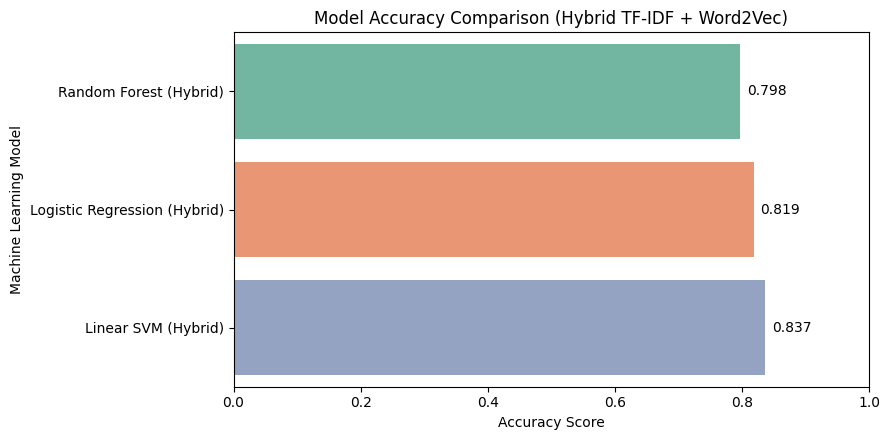

In [73]:
plt.figure(figsize=(9, 4.5))

sns.barplot(
    data=acc_df,
    x="Accuracy",
    y="Model",
    palette="Set2"   # soft, academic-friendly colors
)

plt.xlim(0, 1)
plt.xlabel("Accuracy Score")
plt.ylabel("Machine Learning Model")
plt.title("Model Accuracy Comparison (Hybrid TF-IDF + Word2Vec)")

# Add accuracy labels at the end of each bar
for index, value in enumerate(acc_df["Accuracy"]):
    plt.text(value + 0.01, index, f"{value:.3f}", va="center")

plt.tight_layout()
plt.show()


## Sentiment Comparison Visualization


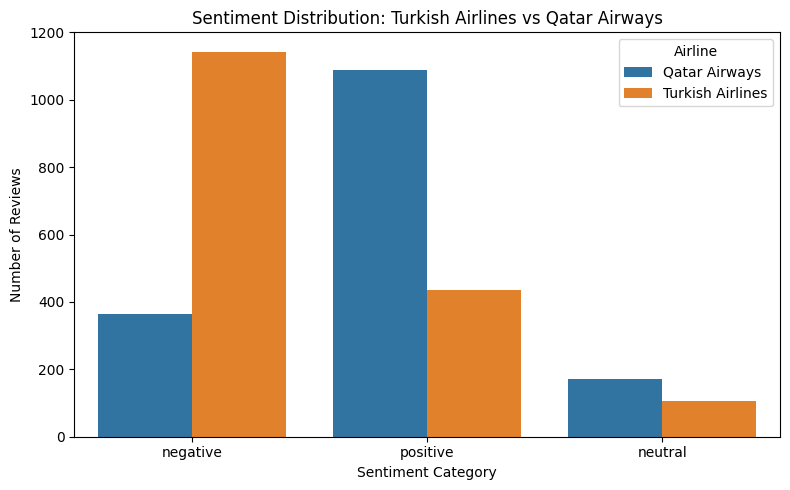

In [ ]:
# Visualize sentiment distribution by airline
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="sentiment", hue="Airline")

plt.title("Sentiment Distribution: Turkish Airlines vs Qatar Airways")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Reviews")

plt.tight_layout()
plt.show()


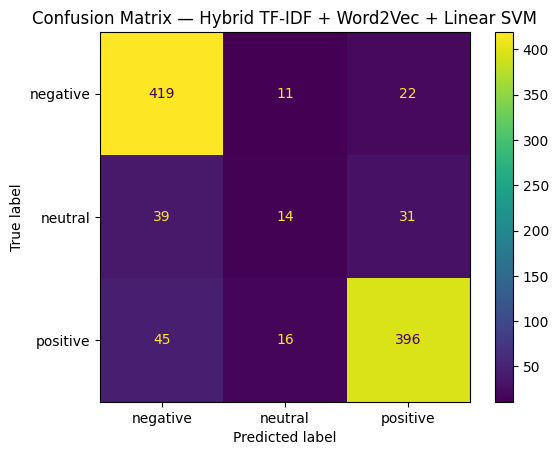

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    svm_hybrid.predict(X_test)
)

plt.title("Confusion Matrix — Hybrid TF-IDF + Word2Vec + Linear SVM")
plt.show()


***DEMO***


In [74]:
def predict_sentiment(text, model, tfidf, w2v_model):
    """
    Predict sentiment for a new review text using
    hybrid TF-IDF + Word2Vec features.
    """

    # Preprocess text
    tokens = preprocess(text)
    clean_text = " ".join(tokens)

    # TF-IDF features
    tfidf_vec = tfidf.transform([clean_text])

    # Word2Vec embedding
    w2v_vec = embed_review(tokens, w2v_model).reshape(1, -1)
    w2v_vec_sparse = csr_matrix(w2v_vec)

    # Hybrid feature
    hybrid_vec = hstack([tfidf_vec, w2v_vec_sparse])

    # Prediction
    prediction = model.predict(hybrid_vec)[0]

    return prediction


In [76]:
new_reviews = [
    "The flight was excellent and the cabin crew were extremely professional.",
    "The service was okay, nothing special but nothing terrible either.",
    "Worst airline experience ever. Delayed flights and rude staff.",
    "Comfortable seats and good food, but the boarding process was chaotic.",
    "The plane was clean but the overall experience was disappointing."
]

for review in new_reviews:
    sentiment = predict_sentiment(
        review,
        svm_hybrid,
        tfidf,
        w2v_model
    )
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment}")
    print("-" * 60)



Review: The flight was excellent and the cabin crew were extremely professional.
Predicted Sentiment: positive
------------------------------------------------------------
Review: The service was okay, nothing special but nothing terrible either.
Predicted Sentiment: negative
------------------------------------------------------------
Review: Worst airline experience ever. Delayed flights and rude staff.
Predicted Sentiment: negative
------------------------------------------------------------
Review: Comfortable seats and good food, but the boarding process was chaotic.
Predicted Sentiment: positive
------------------------------------------------------------
Review: The plane was clean but the overall experience was disappointing.
Predicted Sentiment: neutral
------------------------------------------------------------


In [79]:
import joblib

# Save models
joblib.dump(svm_hybrid, "svm_model.pkl")
joblib.dump(tfidf, "tfidf.pkl")

# Save Word2Vec separately
w2v_model.save("w2v.model")
